# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=40,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_13-47-43/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4827 | MulticlassF1Score=0.1687
Batch-30 : CrossEntropyLoss=2.5062 | MulticlassF1Score=0.2084
Batch-45 : CrossEntropyLoss=2.4557 | MulticlassF1Score=0.2555
Batch-60 : CrossEntropyLoss=2.4461 | MulticlassF1Score=0.2812
Batch-75 : CrossEntropyLoss=2.4539 | MulticlassF1Score=0.3013
Batch-90 : CrossEntropyLoss=2.3941 | MulticlassF1Score=0.3293
Batch-105: CrossEntropyLoss=2.4044 | MulticlassF1Score=0.3638
Batch-120: CrossEntropyLoss=2.3678 | MulticlassF1Score=0.3911
Batch-135: CrossEntropyLoss=2.3839 | MulticlassF1Score=0.4122
Batch-150: CrossEntropyLoss=2.3812 | MulticlassF1Score=0.4291
Batch-165: CrossEntropyLoss=2.3644 | MulticlassF1Score=0.4447
Batch-180: CrossEntropyLoss=2.3747 | MulticlassF1Score=0.4575
Batch-195: CrossEntropyLoss=2.3774 | MulticlassF1Score=0.4683
Batch-210: CrossEntropyLoss=2.3858 | MulticlassF1Score=0.4772
Batch-225: CrossEntropyLoss=2.3811 | MulticlassF1Score=0.4850
Batch-226: CrossEntropyLoss=2.3439 | MulticlassF1Score=0.4854

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3735 | MulticlassF1Score=0.5996
Batch-30 : CrossEntropyLoss=2.3631 | MulticlassF1Score=0.6044
Batch-45 : CrossEntropyLoss=2.3664 | MulticlassF1Score=0.6063
Batch-60 : CrossEntropyLoss=2.3516 | MulticlassF1Score=0.6062
Batch-63 : CrossEntropyLoss=2.3732 | MulticlassF1Score=0.6062

Training   : Mean CrossEntropyLoss = 2.4165 | Mean MulticlassF1Score = 0.3530
Validation : Mean CrossEntropyLoss = 2.3711 | Mean MulticlassF1Score = 0.6022

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3625 | MulticlassF1Score=0.6595
Batch-30 : CrossEntropyLoss=2.3492 | MulticlassF1Score=0.6602
Batch-45 : CrossEntropyLoss=2.3525 | MulticlassF1Score=0.6662
Batch-60 : CrossEntropyLoss=2.3431 | MulticlassF1Score=0.6682
Batch-75 : CrossEntropyLoss=2.3540 | MulticlassF1Score=0.6724
Batch-90 : CrossEntropyLoss=2.3365 | MulticlassF1Score=0.6779
Batch-105: CrossEntropyLoss=2.3375 | MulticlassF1Score=0.6835
Batch-120: CrossEntropyLoss=2.3249 | MulticlassF1Score=0.6879
Batch-135: CrossEntropyLoss=2.3411 | MulticlassF1Score=0.6911
Batch-150: CrossEntropyLoss=2.3427 | MulticlassF1Score=0.6936
Batch-165: CrossEntropyLoss=2.3307 | MulticlassF1Score=0.6958
Batch-180: CrossEntropyLoss=2.3252 | MulticlassF1Score=0.6980
Batch-195: CrossEntropyLoss=2.3403 | MulticlassF1Score=0.6999
Batch-210: CrossEntropyLoss=2.3514 | MulticlassF1Score=0.7020
Batch-225: CrossEntropyLoss=2.3340 | MulticlassF1Score=0.7034
Batch-226: CrossEntropyLoss=2.3201 | MulticlassF1Score=0.7034

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3336 | MulticlassF1Score=0.7233
Batch-30 : CrossEntropyLoss=2.3395 | MulticlassF1Score=0.7251
Batch-45 : CrossEntropyLoss=2.3224 | MulticlassF1Score=0.7250
Batch-60 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7230
Batch-63 : CrossEntropyLoss=2.3500 | MulticlassF1Score=0.7229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3407 | Mean MulticlassF1Score = 0.6813
Validation : Mean CrossEntropyLoss = 2.3343 | Mean MulticlassF1Score = 0.7232

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3276 | MulticlassF1Score=0.7276
Batch-30 : CrossEntropyLoss=2.3469 | MulticlassF1Score=0.7291
Batch-45 : CrossEntropyLoss=2.3259 | MulticlassF1Score=0.7307
Batch-60 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7446
Batch-75 : CrossEntropyLoss=2.3162 | MulticlassF1Score=0.7517
Batch-90 : CrossEntropyLoss=2.3133 | MulticlassF1Score=0.7588
Batch-105: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7639
Batch-120: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7673
Batch-135: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.7700
Batch-150: CrossEntropyLoss=2.3110 | MulticlassF1Score=0.7722
Batch-165: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.7753
Batch-180: CrossEntropyLoss=2.3087 | MulticlassF1Score=0.7787
Batch-195: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.7814
Batch-210: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.7834
Batch-225: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7852
Batch-226: CrossEntropyLoss=2.3199 | MulticlassF1Score=0.7852

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8136
Batch-30 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8126
Batch-45 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8132
Batch-60 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8131
Batch-63 : CrossEntropyLoss=2.3160 | MulticlassF1Score=0.8134

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3150 | Mean MulticlassF1Score = 0.7600
Validation : Mean CrossEntropyLoss = 2.3060 | Mean MulticlassF1Score = 0.8120

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8152
Batch-30 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8166
Batch-45 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8151
Batch-60 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8163
Batch-75 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8145
Batch-90 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8162
Batch-105: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8170
Batch-120: CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8173
Batch-135: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8169
Batch-150: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8170
Batch-165: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8171
Batch-180: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8169
Batch-195: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8170
Batch-210: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8174
Batch-225: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8178
Batch-226: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8178

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8173
Batch-30 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8163
Batch-45 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8169
Batch-60 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8164
Batch-63 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8166

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3044 | Mean MulticlassF1Score = 0.8162
Validation : Mean CrossEntropyLoss = 2.3049 | Mean MulticlassF1Score = 0.8175

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8228
Batch-30 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8275
Batch-45 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8278
Batch-60 : CrossEntropyLoss=2.3146 | MulticlassF1Score=0.8286
Batch-75 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8285
Batch-90 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8280
Batch-105: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8284
Batch-120: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8287
Batch-135: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8296
Batch-150: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8296
Batch-165: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8296
Batch-180: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8301
Batch-195: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8301
Batch-210: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8304
Batch-225: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8304
Batch-226: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8305

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8261
Batch-30 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8259
Batch-45 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8267
Batch-60 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8265
Batch-63 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8264

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3004 | Mean MulticlassF1Score = 0.8284
Validation : Mean CrossEntropyLoss = 2.3019 | Mean MulticlassF1Score = 0.8265

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8269
Batch-30 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8314
Batch-45 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8324
Batch-60 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8311
Batch-75 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8324
Batch-90 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8326
Batch-105: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8331
Batch-120: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8338
Batch-135: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8334
Batch-150: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8340
Batch-165: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8329
Batch-180: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8328
Batch-195: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8328
Batch-210: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8330
Batch-225: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8330
Batch-226: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8330

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8282
Batch-30 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8274
Batch-45 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8289
Batch-60 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8278
Batch-63 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8278

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2994 | Mean MulticlassF1Score = 0.8324
Validation : Mean CrossEntropyLoss = 2.3011 | Mean MulticlassF1Score = 0.8281

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8327
Batch-30 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8380
Batch-45 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8365
Batch-60 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8346
Batch-75 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8340
Batch-90 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8344
Batch-105: CrossEntropyLoss=2.3111 | MulticlassF1Score=0.8340
Batch-120: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8345
Batch-135: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8347
Batch-150: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8350
Batch-165: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8348
Batch-180: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8346
Batch-195: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8348
Batch-210: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8347
Batch-225: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8346
Batch-226: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8347

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8300
Batch-30 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8269
Batch-45 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8288
Batch-60 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8297
Batch-63 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8296

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2988 | Mean MulticlassF1Score = 0.8350
Validation : Mean CrossEntropyLoss = 2.3006 | Mean MulticlassF1Score = 0.8289

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8373
Batch-30 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8349
Batch-45 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8364
Batch-60 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8367
Batch-75 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8375
Batch-90 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8373
Batch-105: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8371
Batch-120: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8371
Batch-135: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8368
Batch-150: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8369
Batch-165: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8364
Batch-180: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8366
Batch-195: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8363
Batch-210: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8361
Batch-225: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8362
Batch-226: CrossEntropyLoss=2.3108 | MulticlassF1Score=0.8361

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8351
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8329
Batch-45 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8331
Batch-60 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8305
Batch-63 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8301

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2983 | Mean MulticlassF1Score = 0.8365
Validation : Mean CrossEntropyLoss = 2.3003 | Mean MulticlassF1Score = 0.8327

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8330
Batch-30 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8349
Batch-45 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8360
Batch-60 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8361
Batch-75 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8367
Batch-90 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8367
Batch-105: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8372
Batch-120: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8374
Batch-135: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8383
Batch-150: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8386
Batch-165: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8395
Batch-180: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8399
Batch-195: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8406
Batch-210: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8407
Batch-225: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8408
Batch-226: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8408

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8379
Batch-30 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8391
Batch-45 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8377
Batch-60 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8386
Batch-63 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8387

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2968 | Mean MulticlassF1Score = 0.8372
Validation : Mean CrossEntropyLoss = 2.2977 | Mean MulticlassF1Score = 0.8382

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8464
Batch-30 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8469
Batch-45 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8492
Batch-60 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8480
Batch-75 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8470
Batch-90 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8469
Batch-105: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8474
Batch-120: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8462
Batch-135: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8466
Batch-150: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8481
Batch-165: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8490
Batch-180: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8497
Batch-195: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8503
Batch-210: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8510
Batch-225: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8517
Batch-226: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8517

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8657
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8637
Batch-45 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8651
Batch-60 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8662
Batch-63 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8658

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2936 | Mean MulticlassF1Score = 0.8483
Validation : Mean CrossEntropyLoss = 2.2903 | Mean MulticlassF1Score = 0.8659

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8748
Batch-30 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8779
Batch-45 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8804
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8828
Batch-75 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8837
Batch-90 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8843
Batch-105: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8850
Batch-120: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8855
Batch-135: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8865
Batch-150: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8868
Batch-165: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8867
Batch-180: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8869
Batch-195: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8871
Batch-210: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8872
Batch-225: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8876
Batch-226: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8875

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8759
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8813
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8832
Batch-60 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8826
Batch-63 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8830

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8836
Validation : Mean CrossEntropyLoss = 2.2843 | Mean MulticlassF1Score = 0.8806

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8960
Batch-30 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8920
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8915
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8923
Batch-75 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8922
Batch-90 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8921
Batch-105: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8920
Batch-120: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8923
Batch-135: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8925
Batch-150: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8924
Batch-165: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8927
Batch-180: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8930
Batch-195: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8930
Batch-210: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8929
Batch-225: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8926
Batch-226: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8926

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8868
Batch-30 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8862
Batch-45 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8857
Batch-60 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8860
Batch-63 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8854

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8923
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8871

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8949
Batch-30 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8953
Batch-45 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8946
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8940
Batch-75 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8941
Batch-90 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8942
Batch-105: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8941
Batch-120: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8941
Batch-135: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8948
Batch-150: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8947
Batch-165: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.8951
Batch-180: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8953
Batch-195: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8953
Batch-210: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8949
Batch-225: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8952
Batch-226: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8951

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8890
Batch-30 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8885
Batch-45 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8871
Batch-60 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8857
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8860

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2802 | Mean MulticlassF1Score = 0.8947
Validation : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8867

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8925
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8947
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8974
Batch-60 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8973
Batch-75 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8976
Batch-90 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8973
Batch-105: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8978
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8972
Batch-135: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8975
Batch-150: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8977
Batch-165: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8978
Batch-180: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8975
Batch-195: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8970
Batch-210: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8970
Batch-225: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8971
Batch-226: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8971

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8872
Batch-30 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8885
Batch-45 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8875
Batch-60 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8867
Batch-63 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8862

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8967
Validation : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8876

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8982
Batch-30 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8978
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.8995
Batch-60 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8990
Batch-75 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8975
Batch-90 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8972
Batch-105: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8973
Batch-120: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8973
Batch-135: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8974
Batch-150: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8976
Batch-165: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8979
Batch-180: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8980
Batch-195: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8978
Batch-210: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.8981
Batch-225: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8983
Batch-226: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8982

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8900
Batch-30 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8878
Batch-45 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8893
Batch-60 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8876
Batch-63 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8874

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2791 | Mean MulticlassF1Score = 0.8980
Validation : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8901

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8937
Batch-30 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8947
Batch-45 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8970
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8977
Batch-75 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8984
Batch-90 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8991
Batch-105: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8992
Batch-120: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8997
Batch-135: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8995
Batch-150: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8998
Batch-165: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8995
Batch-180: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8995
Batch-195: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.8994
Batch-210: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8992
Batch-225: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8994
Batch-226: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8993

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8852
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8869
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8868
Batch-60 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8879
Batch-63 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8873

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2788 | Mean MulticlassF1Score = 0.8981
Validation : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8863

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9039
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9012
Batch-45 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9011
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9017
Batch-75 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9014
Batch-90 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9010
Batch-105: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9001
Batch-120: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.8998
Batch-135: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8998
Batch-150: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8995
Batch-165: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.8998
Batch-180: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8996
Batch-195: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.8995
Batch-210: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9000
Batch-225: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9002
Batch-226: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9002

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8897
Batch-30 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8870
Batch-45 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8871
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8878
Batch-63 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8878

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2784 | Mean MulticlassF1Score = 0.9008
Validation : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8885

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9023
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9049
Batch-45 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9037
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9023
Batch-75 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9018
Batch-90 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.9013
Batch-105: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.9008
Batch-120: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9012
Batch-135: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9009
Batch-150: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9012
Batch-165: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9012
Batch-180: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9012
Batch-195: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9005
Batch-210: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9006
Batch-225: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9008
Batch-226: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9008

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8880
Batch-30 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8877
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8871
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8872
Batch-63 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8874

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2782 | Mean MulticlassF1Score = 0.9015
Validation : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8869

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9031
Batch-30 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9014
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9010
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9008
Batch-75 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9005
Batch-90 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9008
Batch-105: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9009
Batch-120: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.9008
Batch-135: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9004
Batch-150: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9004
Batch-165: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9004
Batch-180: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9008
Batch-195: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.9012
Batch-210: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9015
Batch-225: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9016
Batch-226: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9016

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8913
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8881
Batch-45 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8876
Batch-60 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8896
Batch-63 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8890

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2780 | Mean MulticlassF1Score = 0.9007
Validation : Mean CrossEntropyLoss = 2.2820 | Mean MulticlassF1Score = 0.8897

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9027
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9051
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9059
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9069
Batch-75 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9070
Batch-90 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9069
Batch-105: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9081
Batch-120: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9108
Batch-135: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9124
Batch-150: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9138
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9152
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9166
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9175
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9187
Batch-225: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9195
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9196

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9204
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9190
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9193
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9197
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9195

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9104
Validation : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9205

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9338
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9334
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9324
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9339
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9350
Batch-90 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9348
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9351
Batch-120: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9350
Batch-135: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9352
Batch-150: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9351
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9355
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9355
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9352
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9351
Batch-225: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9353
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9353

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9216
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9226
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9228
Batch-63 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2678 | Mean MulticlassF1Score = 0.9349
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9224

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9359
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9360
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9357
Batch-75 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9354
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9359
Batch-105: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9367
Batch-120: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9371
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9370
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9371
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9371
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9370
Batch-195: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9372
Batch-210: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9372
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9372
Batch-226: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9372

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9208
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9244
Batch-45 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9236

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9368
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9234

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9343
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9377
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9394
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9380
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9386
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9389
Batch-120: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9387
Batch-135: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9382
Batch-150: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9386
Batch-165: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9383
Batch-180: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9385
Batch-195: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9389
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9390
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9392
Batch-226: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9392

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9267
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9239

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9382
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9227

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9418
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9422
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9417
Batch-105: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9416
Batch-120: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9413
Batch-150: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9408
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9409
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9407
Batch-210: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9405
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9405
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9405

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9261
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9244
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9244

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9413
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9256

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9396
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9408
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9409
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9412
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9415
Batch-150: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9414
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9416
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9414
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9417
Batch-210: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9412
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9412

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9223
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9222
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9242
Batch-63 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9241

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9410
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9223

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9430
Batch-90 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9427
Batch-105: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9424
Batch-120: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9427
Batch-135: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9420
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9425
Batch-165: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9425
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9423
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9419
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9418
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9415
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9416

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9244
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9245
Batch-63 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9241

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9424
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9253

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9432
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9429
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9427
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9430
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9426
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9422
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9424
Batch-195: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9422
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9420
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9418
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9418

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9213
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9433
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9216

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9418
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9424
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9425
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9428
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9423
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9420
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9424
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9423
Batch-180: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9424
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9423
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9422
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9421
Batch-226: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9421

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9244
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9241
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9238
Batch-63 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9241

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9417
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9239

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9410
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9417
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9422
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9424
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9430
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9428
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9426
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9427
Batch-150: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9427
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9426
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9427
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9426
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9426
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9423
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9424

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9242
Batch-63 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.9242

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9424
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9253

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9417
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9427
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9437
Batch-90 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9436
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9432
Batch-120: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9433
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9435
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9432
Batch-165: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9429
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9430
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9430
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9430
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9429
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9428

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9235
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9238

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9266

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9437
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9434
Batch-105: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9430
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9432
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9436
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9435
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9432
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9432
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9432
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9432
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9432

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9281
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9260
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9252

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9430
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9267

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9439
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9442
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9438
Batch-105: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9433
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9432
Batch-195: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9436
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9435
Batch-225: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9436
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9437

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9229
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9240

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9438
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9237

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9431
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9434
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9435
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9433
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9436
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9437
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9435
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9437
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9436
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9438
Batch-225: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9437
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9437

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9241
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9248
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9247

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9434
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9251

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9401
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9434
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9430
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9438
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9438
Batch-105: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9441
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9443
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9444
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9443
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9443
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9441
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9441
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9440
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9252
Batch-63 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9434
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9248

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9441
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9437
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9441
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9439
Batch-120: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9443
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9443
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9445
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9442

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9238
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9440
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9224

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9450
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9451
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9447
Batch-135: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9450
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9448
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9450
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9450
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9448
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9449

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9277
Batch-30 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9261
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9447
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9262

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9451
Batch-75 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9455
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9457
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9458
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9453
Batch-135: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9459
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9460
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9462
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9460
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9457
Batch-210: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9454
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9453
Batch-226: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9453

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9213
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9226
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9251
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9459
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9236

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9423
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9449
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9457
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9459
Batch-120: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9461
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9463
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9463
Batch-165: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9462
Batch-180: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9458
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9458
Batch-210: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9457
Batch-225: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9458
Batch-226: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9458

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9279
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9298
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9286
Batch-60 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9267
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9264

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9454
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9284

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9468
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9474
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9465
Batch-105: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9463
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9458
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9457
Batch-165: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9460
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9461
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9461
Batch-225: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9460
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9460

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9254
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9250
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9251

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9464
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9255

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9476
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9474
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9481
Batch-105: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9479
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9471
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9465
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9465
Batch-180: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9467
Batch-195: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9466
Batch-210: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9465
Batch-225: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9464
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9242
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9476
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9246

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9473
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9473
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9474
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9471
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9467
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9466
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9460
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9460
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9460

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9207
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9246
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9245

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9467
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9224
Patience = 1/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9496
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9477
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9474
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9470
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9466
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9465
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9461
Batch-165: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9462
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9461
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9458
Batch-210: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9457
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9458
Batch-226: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9457

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9238
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9242
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9250
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9254

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9469
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9241
Patience = 2/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9451
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9460
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9464
Batch-105: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9464
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9461
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9461
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9462
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9461
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9465
Batch-225: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9461

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9294
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9273

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9419
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9456
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9468
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9468
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9466
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9466
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9465
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9465
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9465

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9256
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9460
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9259

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9465
Batch-75 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9469
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9467
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9465
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9464
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9466
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9467
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9469
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9472
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9475
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9475

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9315
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9288
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9277
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9272

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9471
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9293

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9476
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9472
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9475
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9473
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9471
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9471
Batch-150: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9477
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9479
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9483
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9482
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9483
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9482
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9270
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9271
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9269
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9268

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9477
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9261

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9492
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9488
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9486
Batch-105: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9488
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9494
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9491
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9486
Batch-165: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9478
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9472
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9468
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9464
Batch-226: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9463

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9225
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9244
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9249

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9483
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9239
Patience = 3/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9450
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9445
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9446
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9449
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9447
Batch-150: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9450
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9441
Batch-195: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9440
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9442
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9442

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9271
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9250

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9448
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9276
Patience = 4/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9427
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9464
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9459
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9453
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9453
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9457
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9462
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9461
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9463
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9463
Batch-210: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9464
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9462

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9311
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9291
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9271

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9454
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9288

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9490
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9495
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9485
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9489
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9494
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9497
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9495
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9495
Batch-150: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9494
Batch-165: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9490
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9488
Batch-195: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9483
Batch-210: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9481
Batch-225: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9482
Batch-226: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9483

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9269
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9286
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9276
Batch-63 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9491
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9276

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2634
Best CrossEntropyLoss training    : 2.2698
Best MulticlassF1Score validation : 0.9491
Best MulticlassF1Score validation : 0.9276
Training duration                 : 2.5357 minutes.
Training date                     : 2022-10-19 10:20:27.985244+08:00


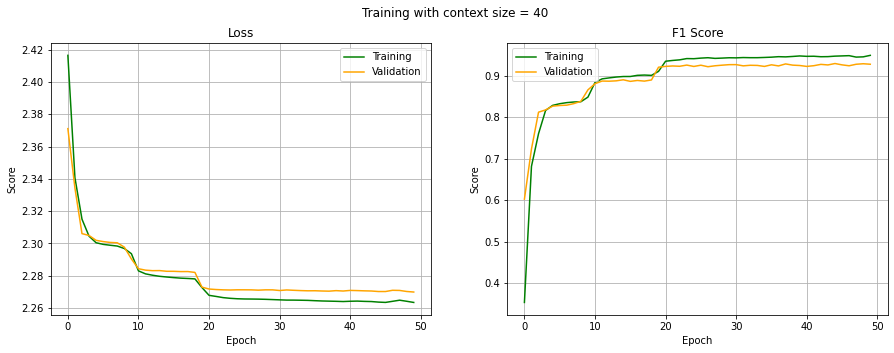

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9505, device='cuda:0'),
 tensor(0.9275, device='cuda:0'),
 tensor(0.9275, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9505, device='cuda:0'),
 tensor(0.9275, device='cuda:0'),
 tensor(0.9275, device='cuda:0'))

## Heatmap

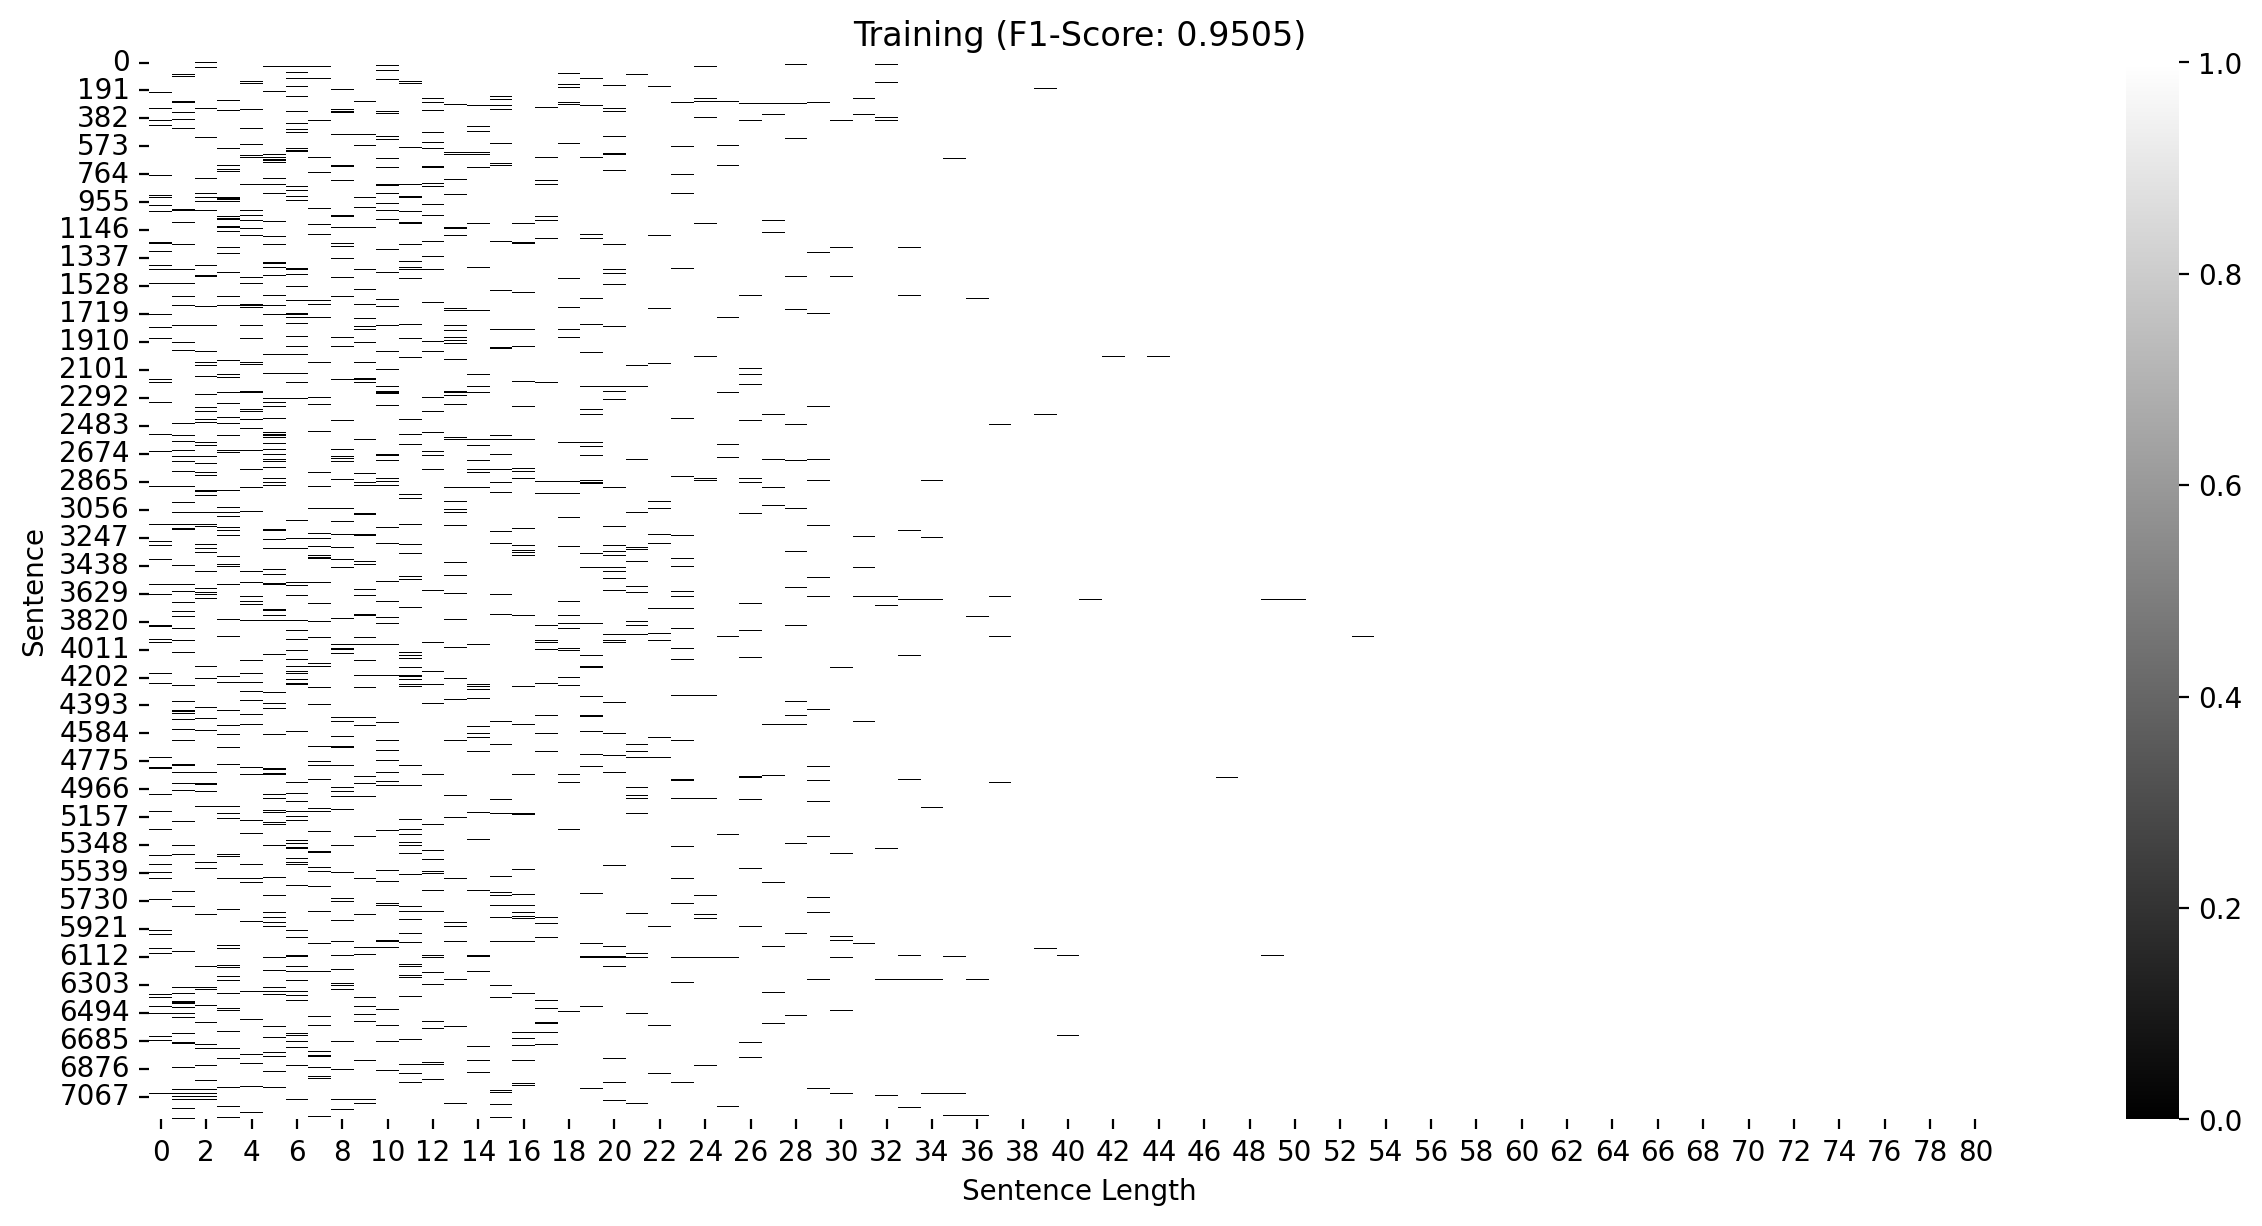

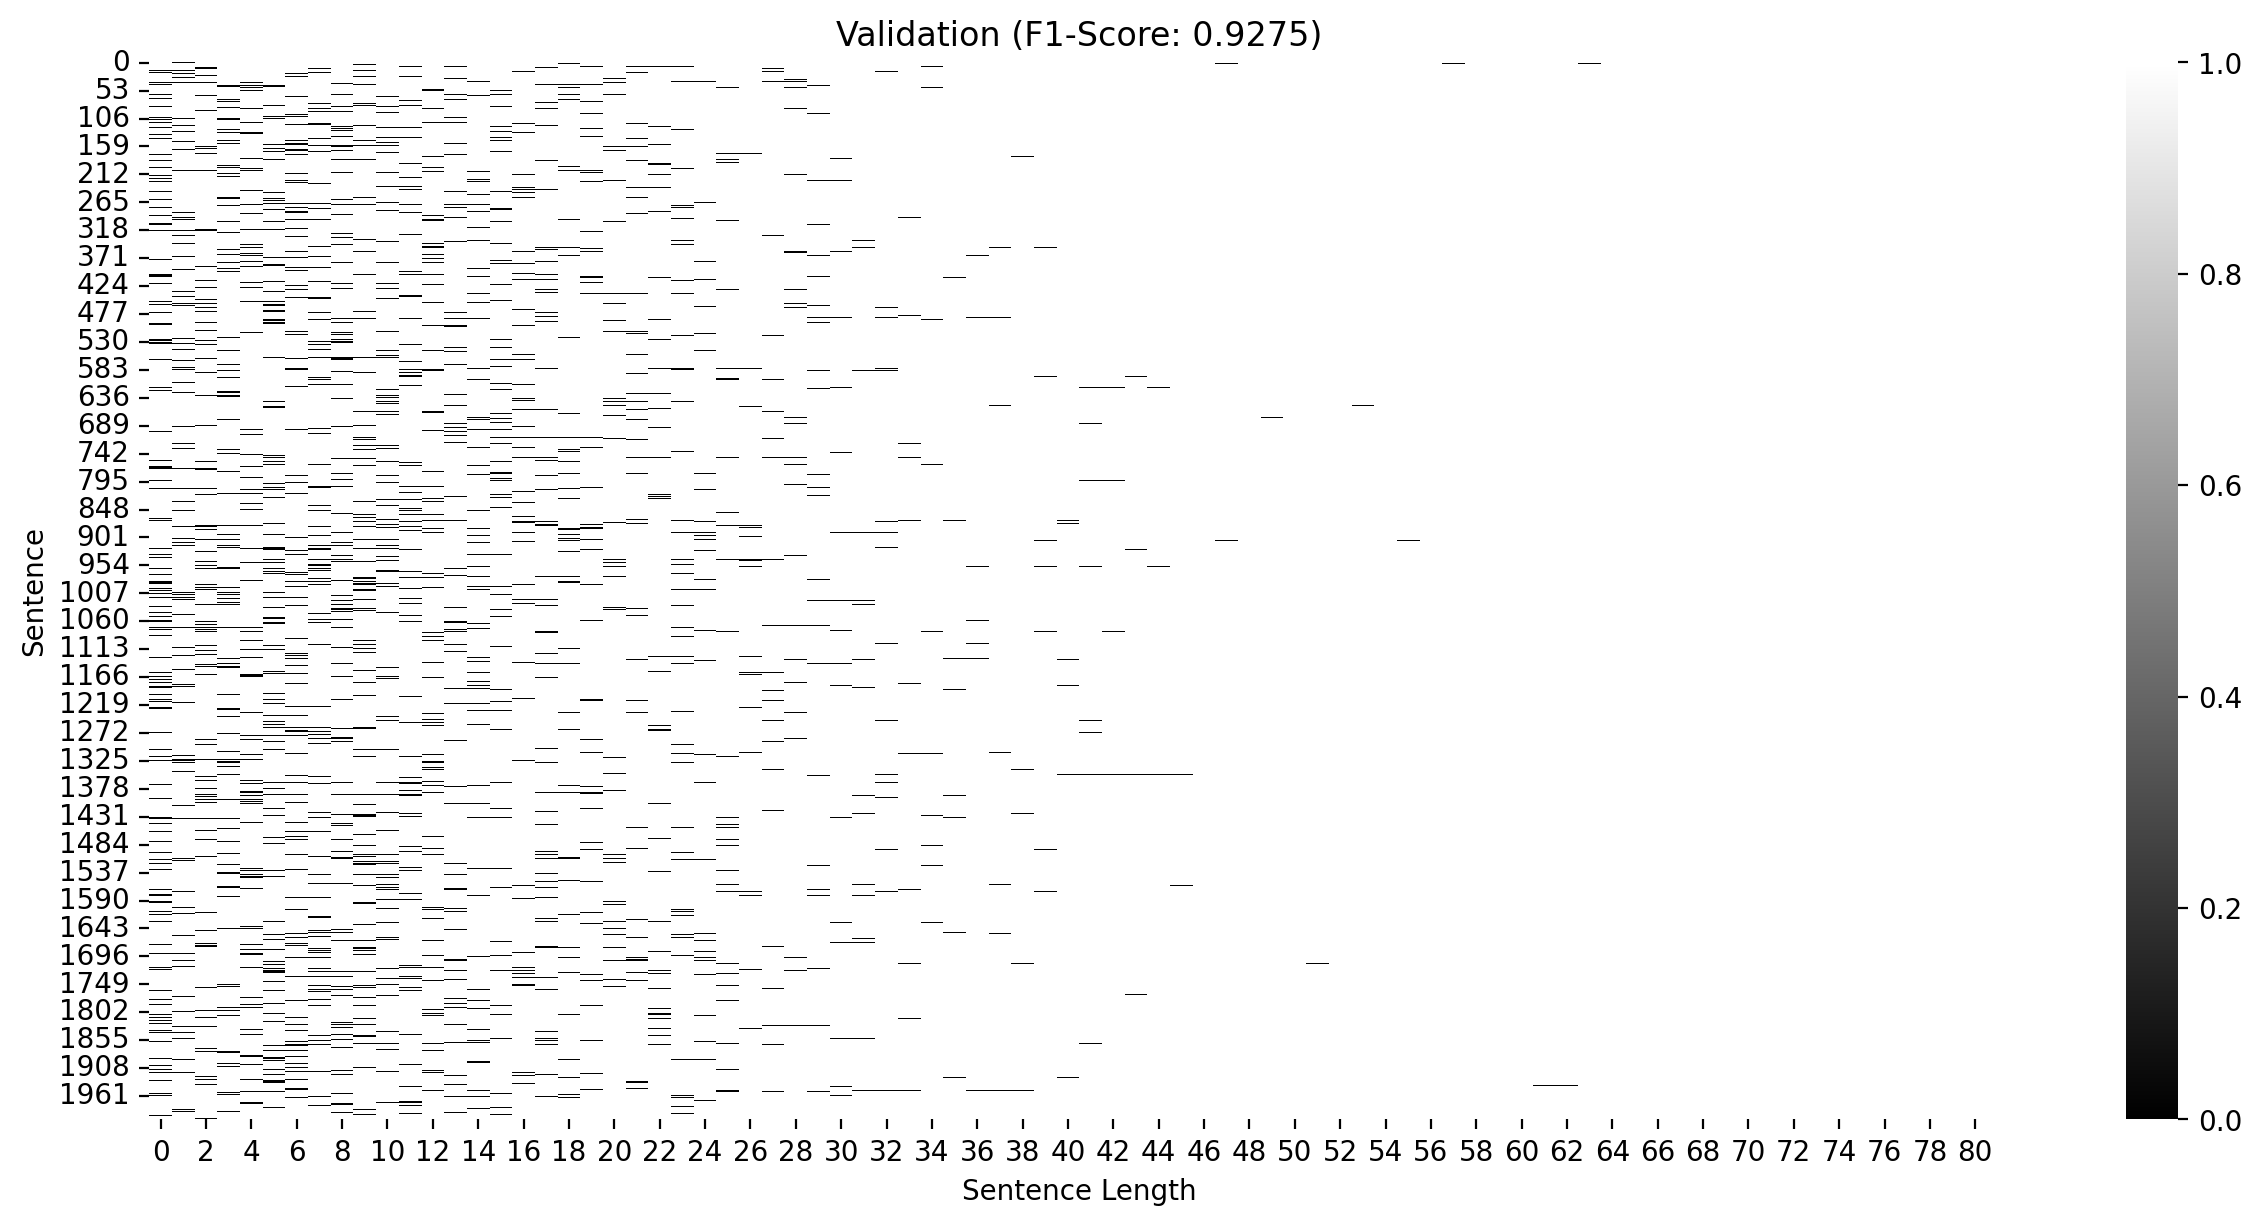

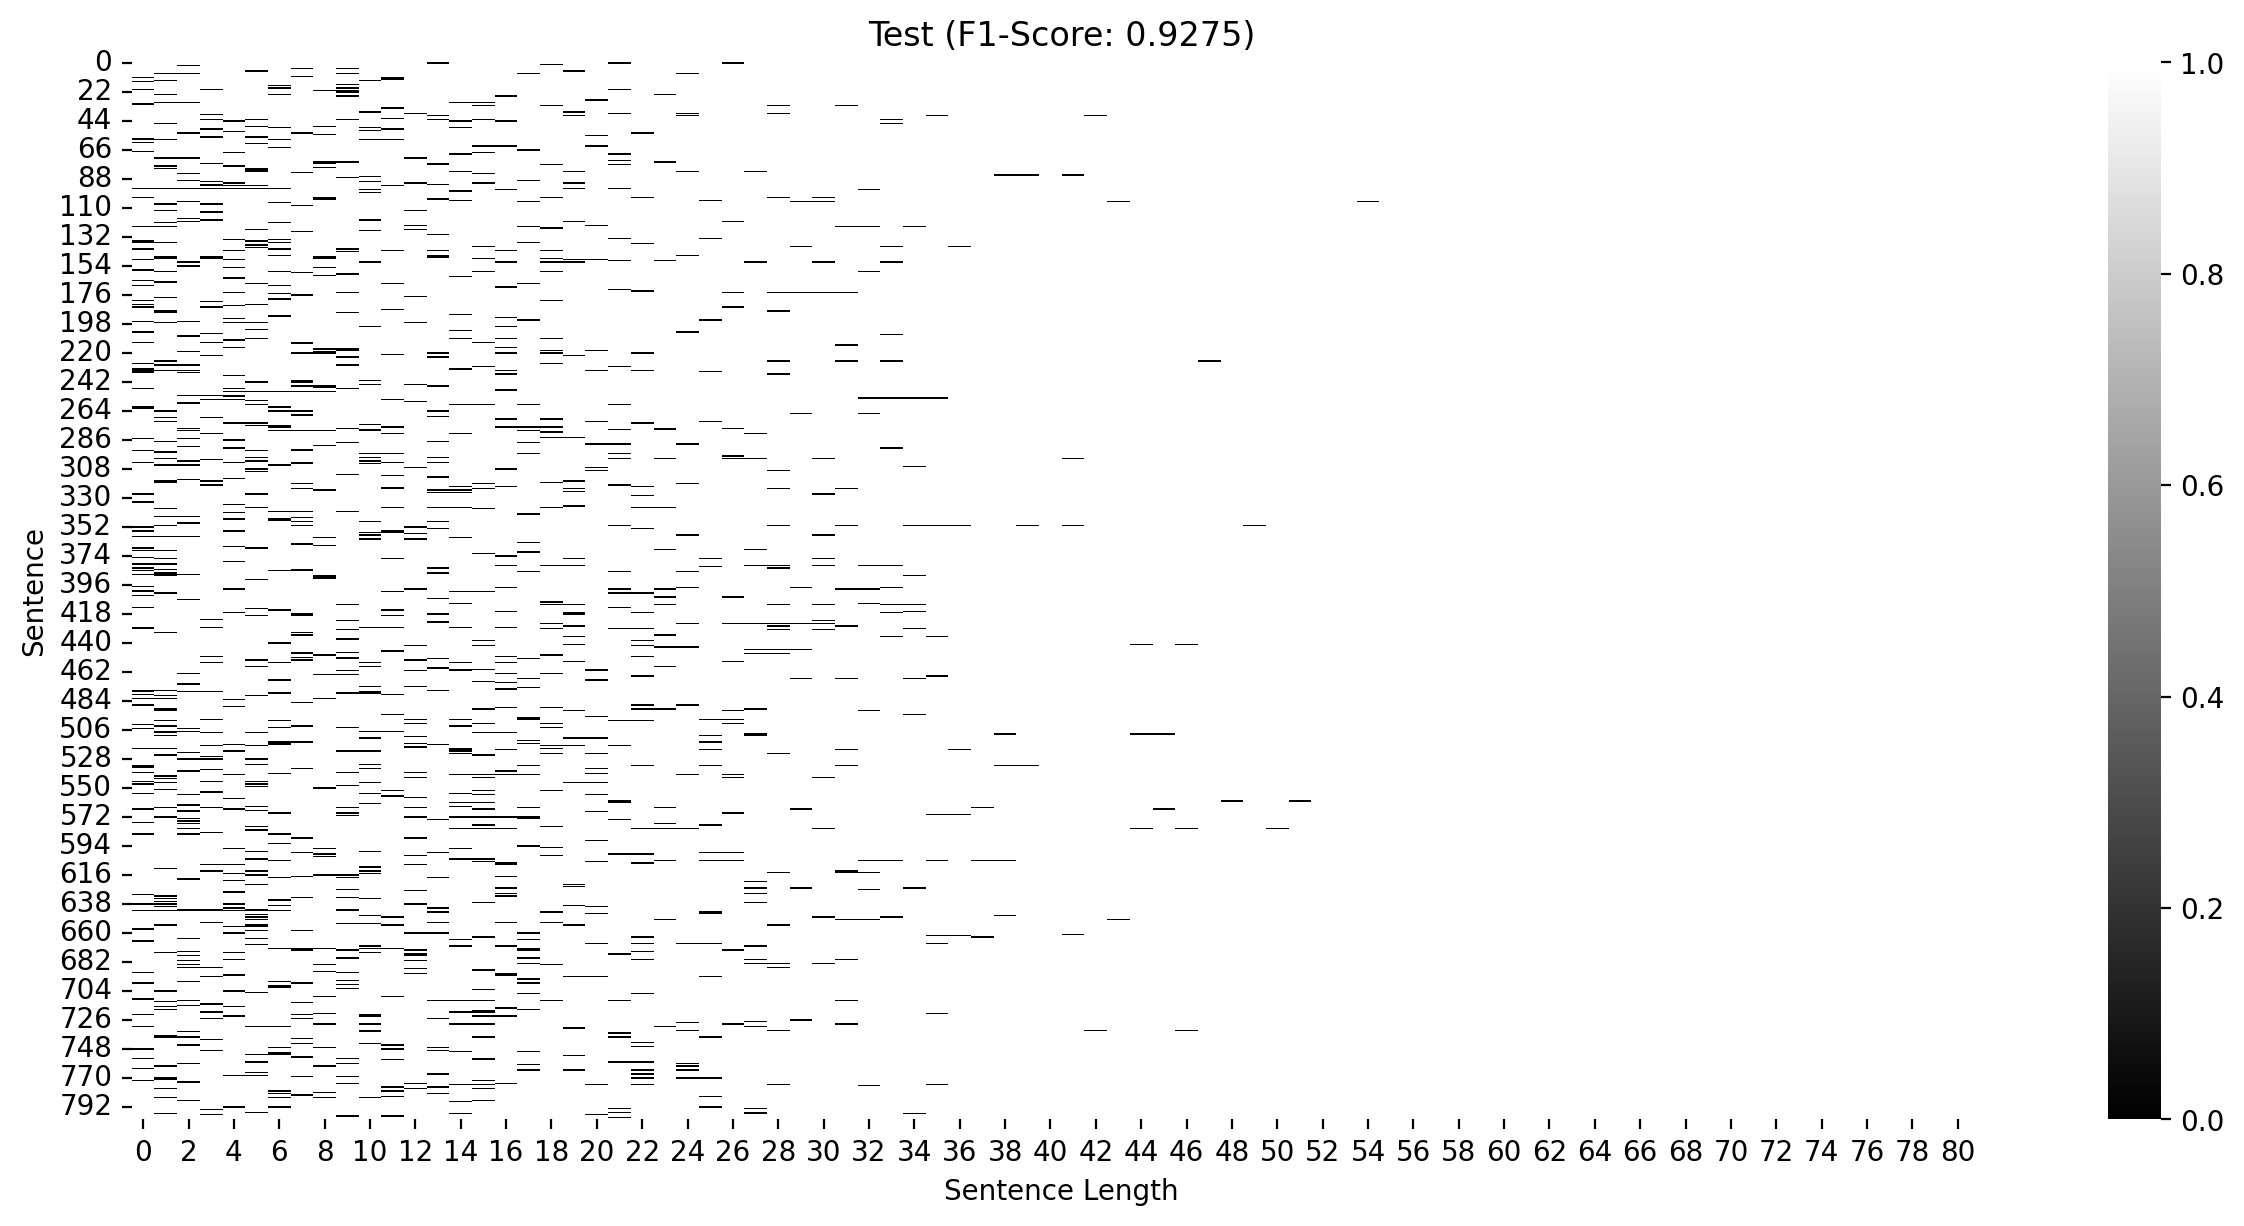

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 96 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


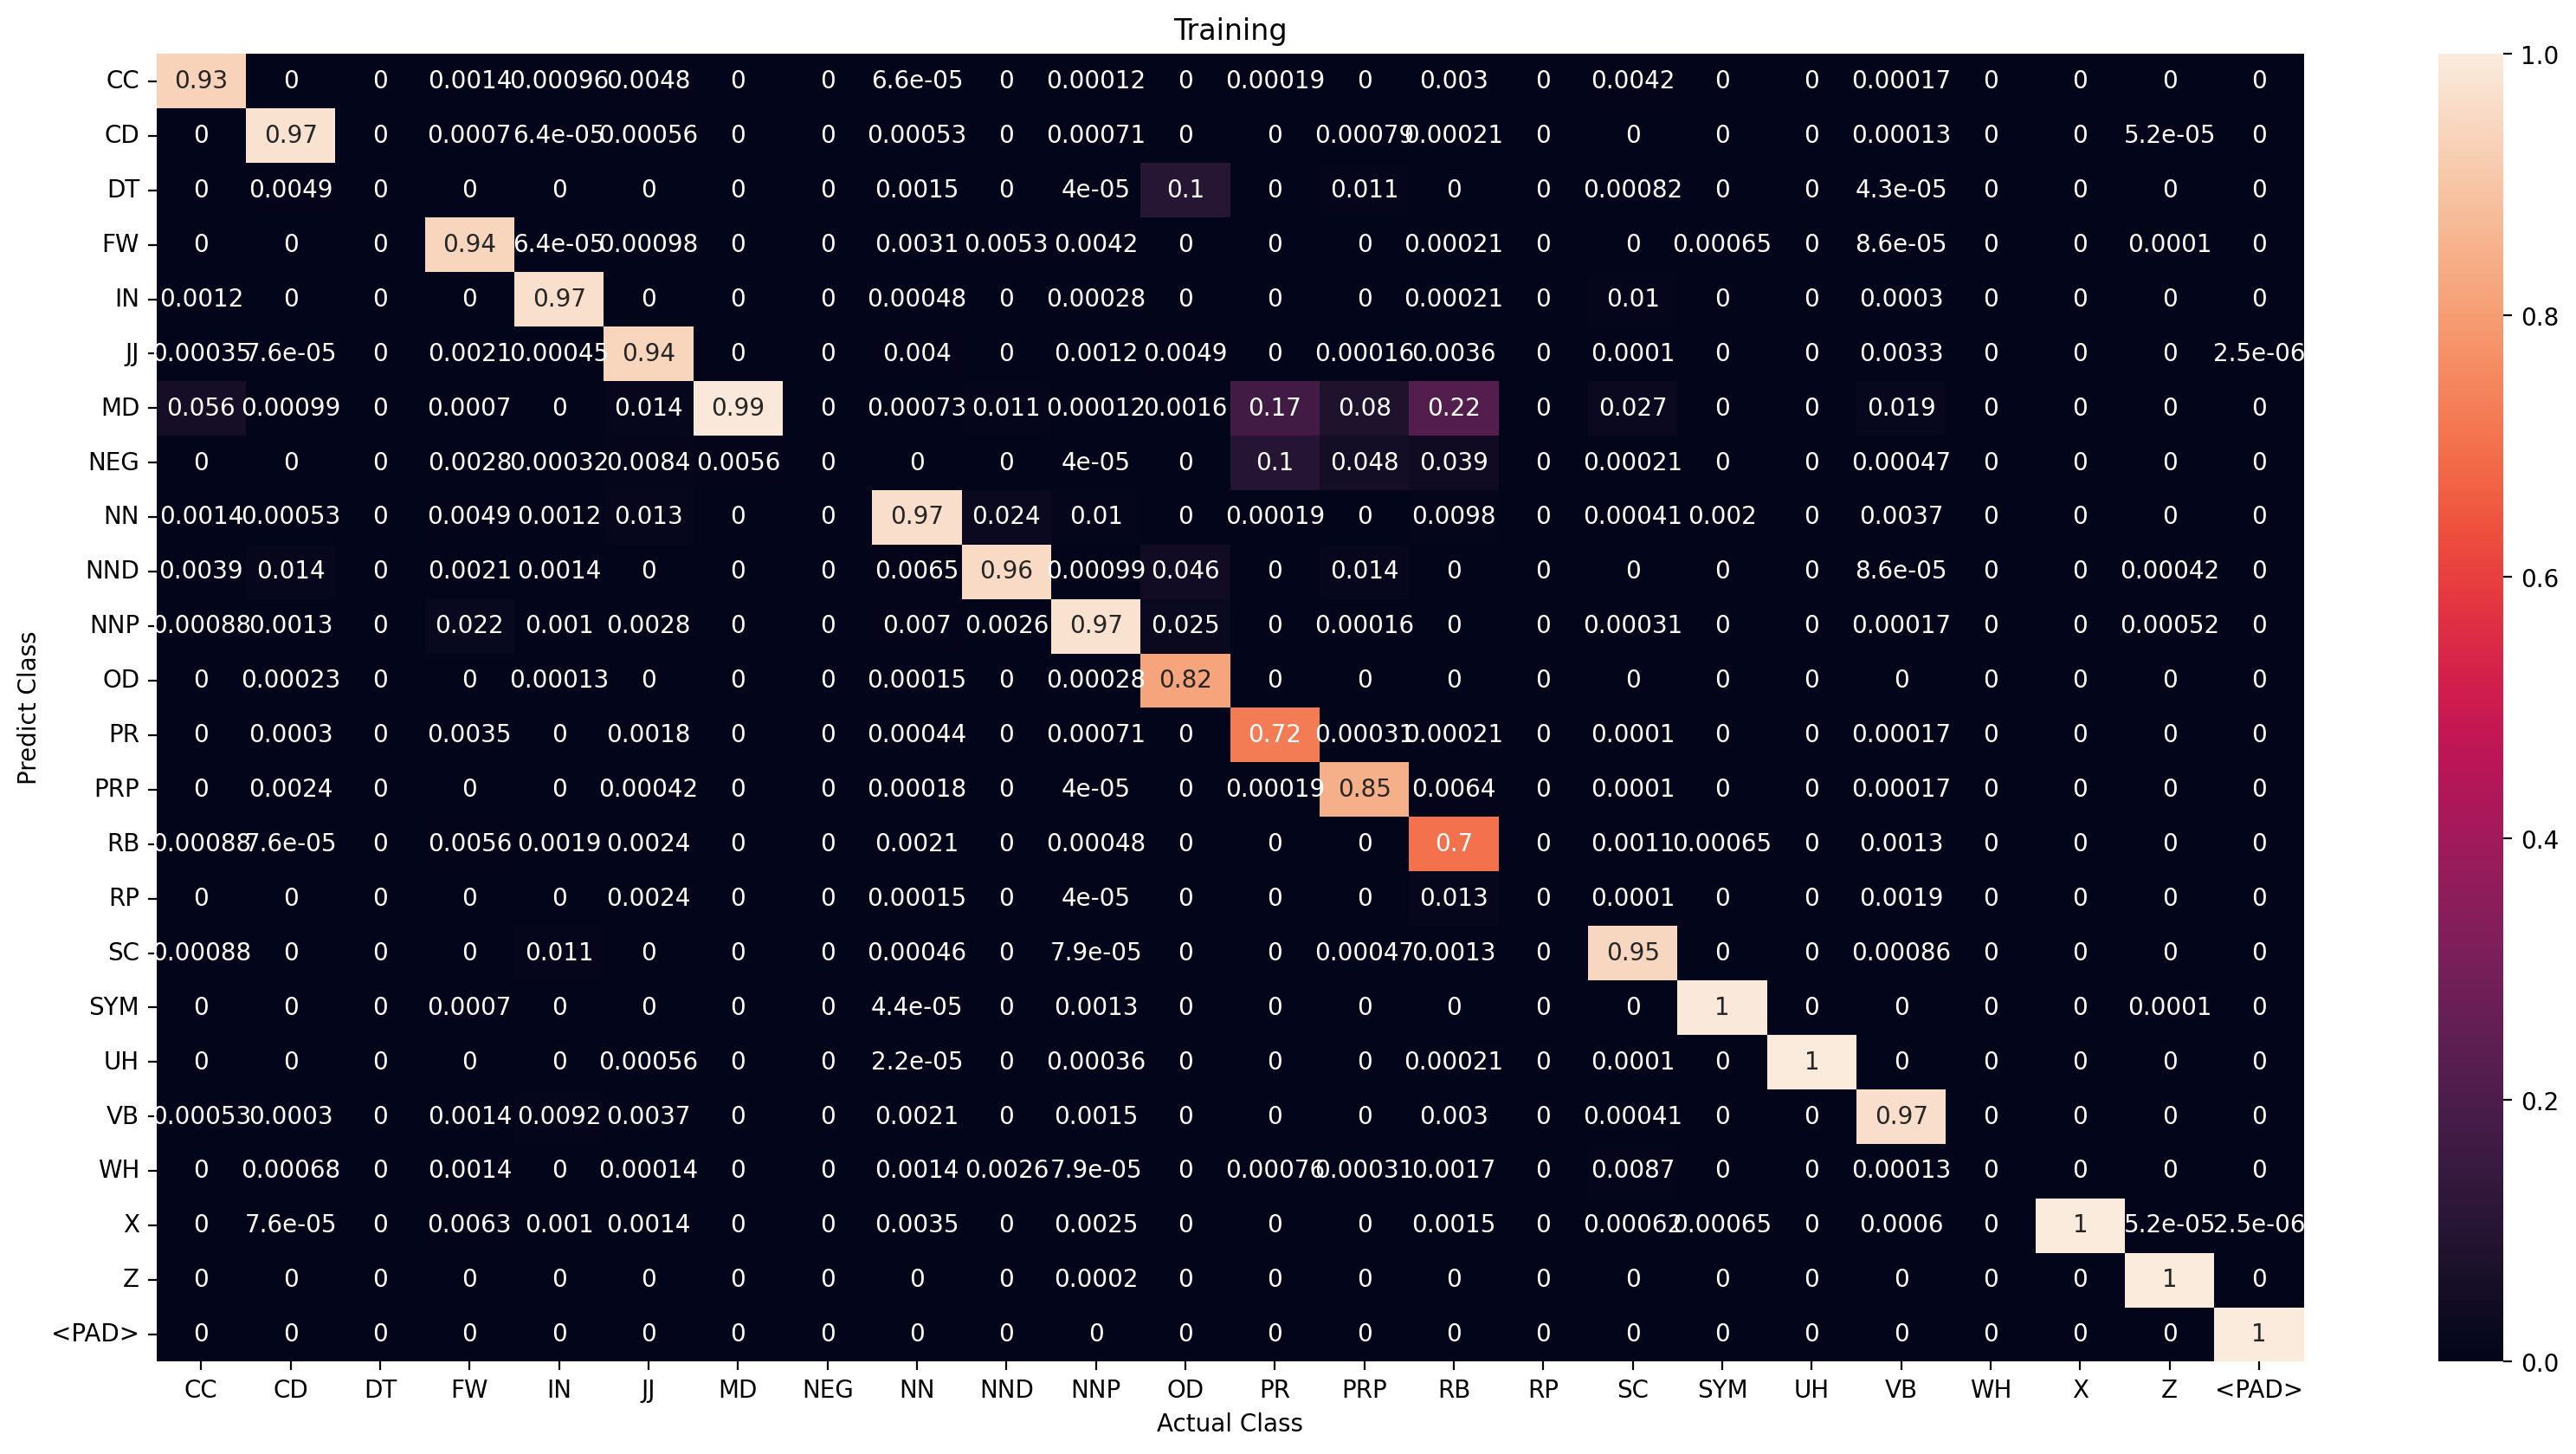

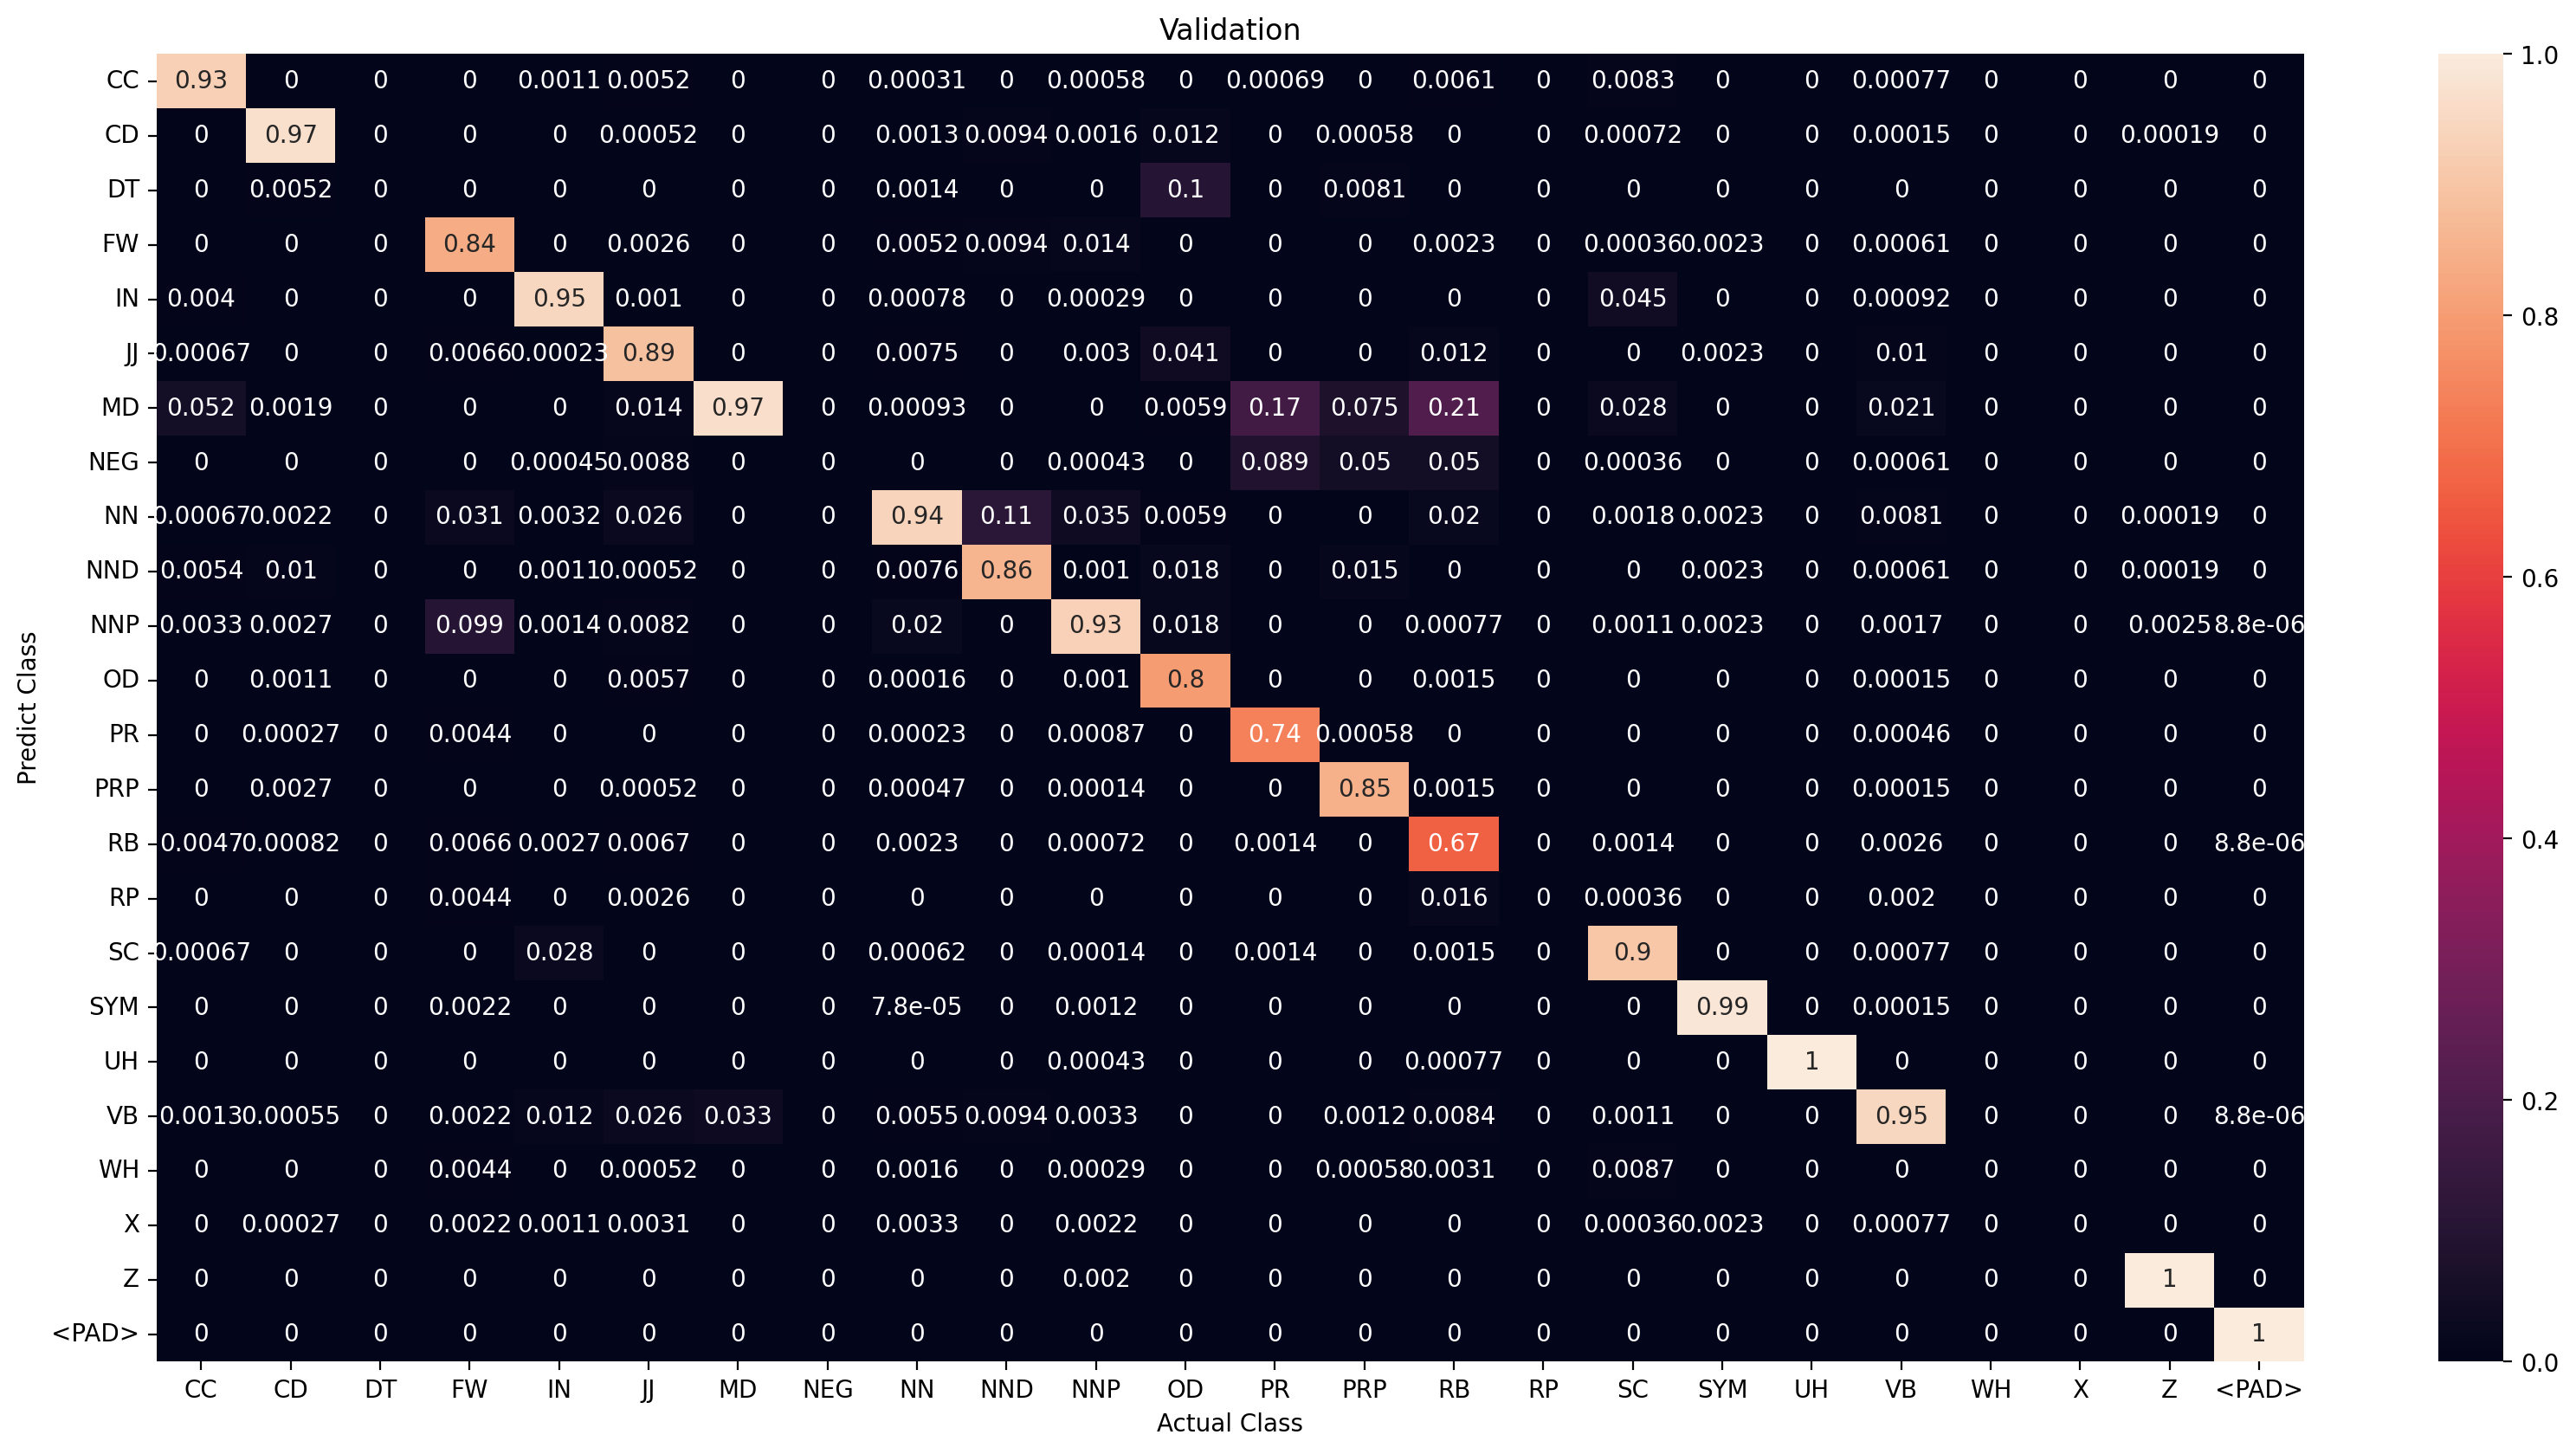

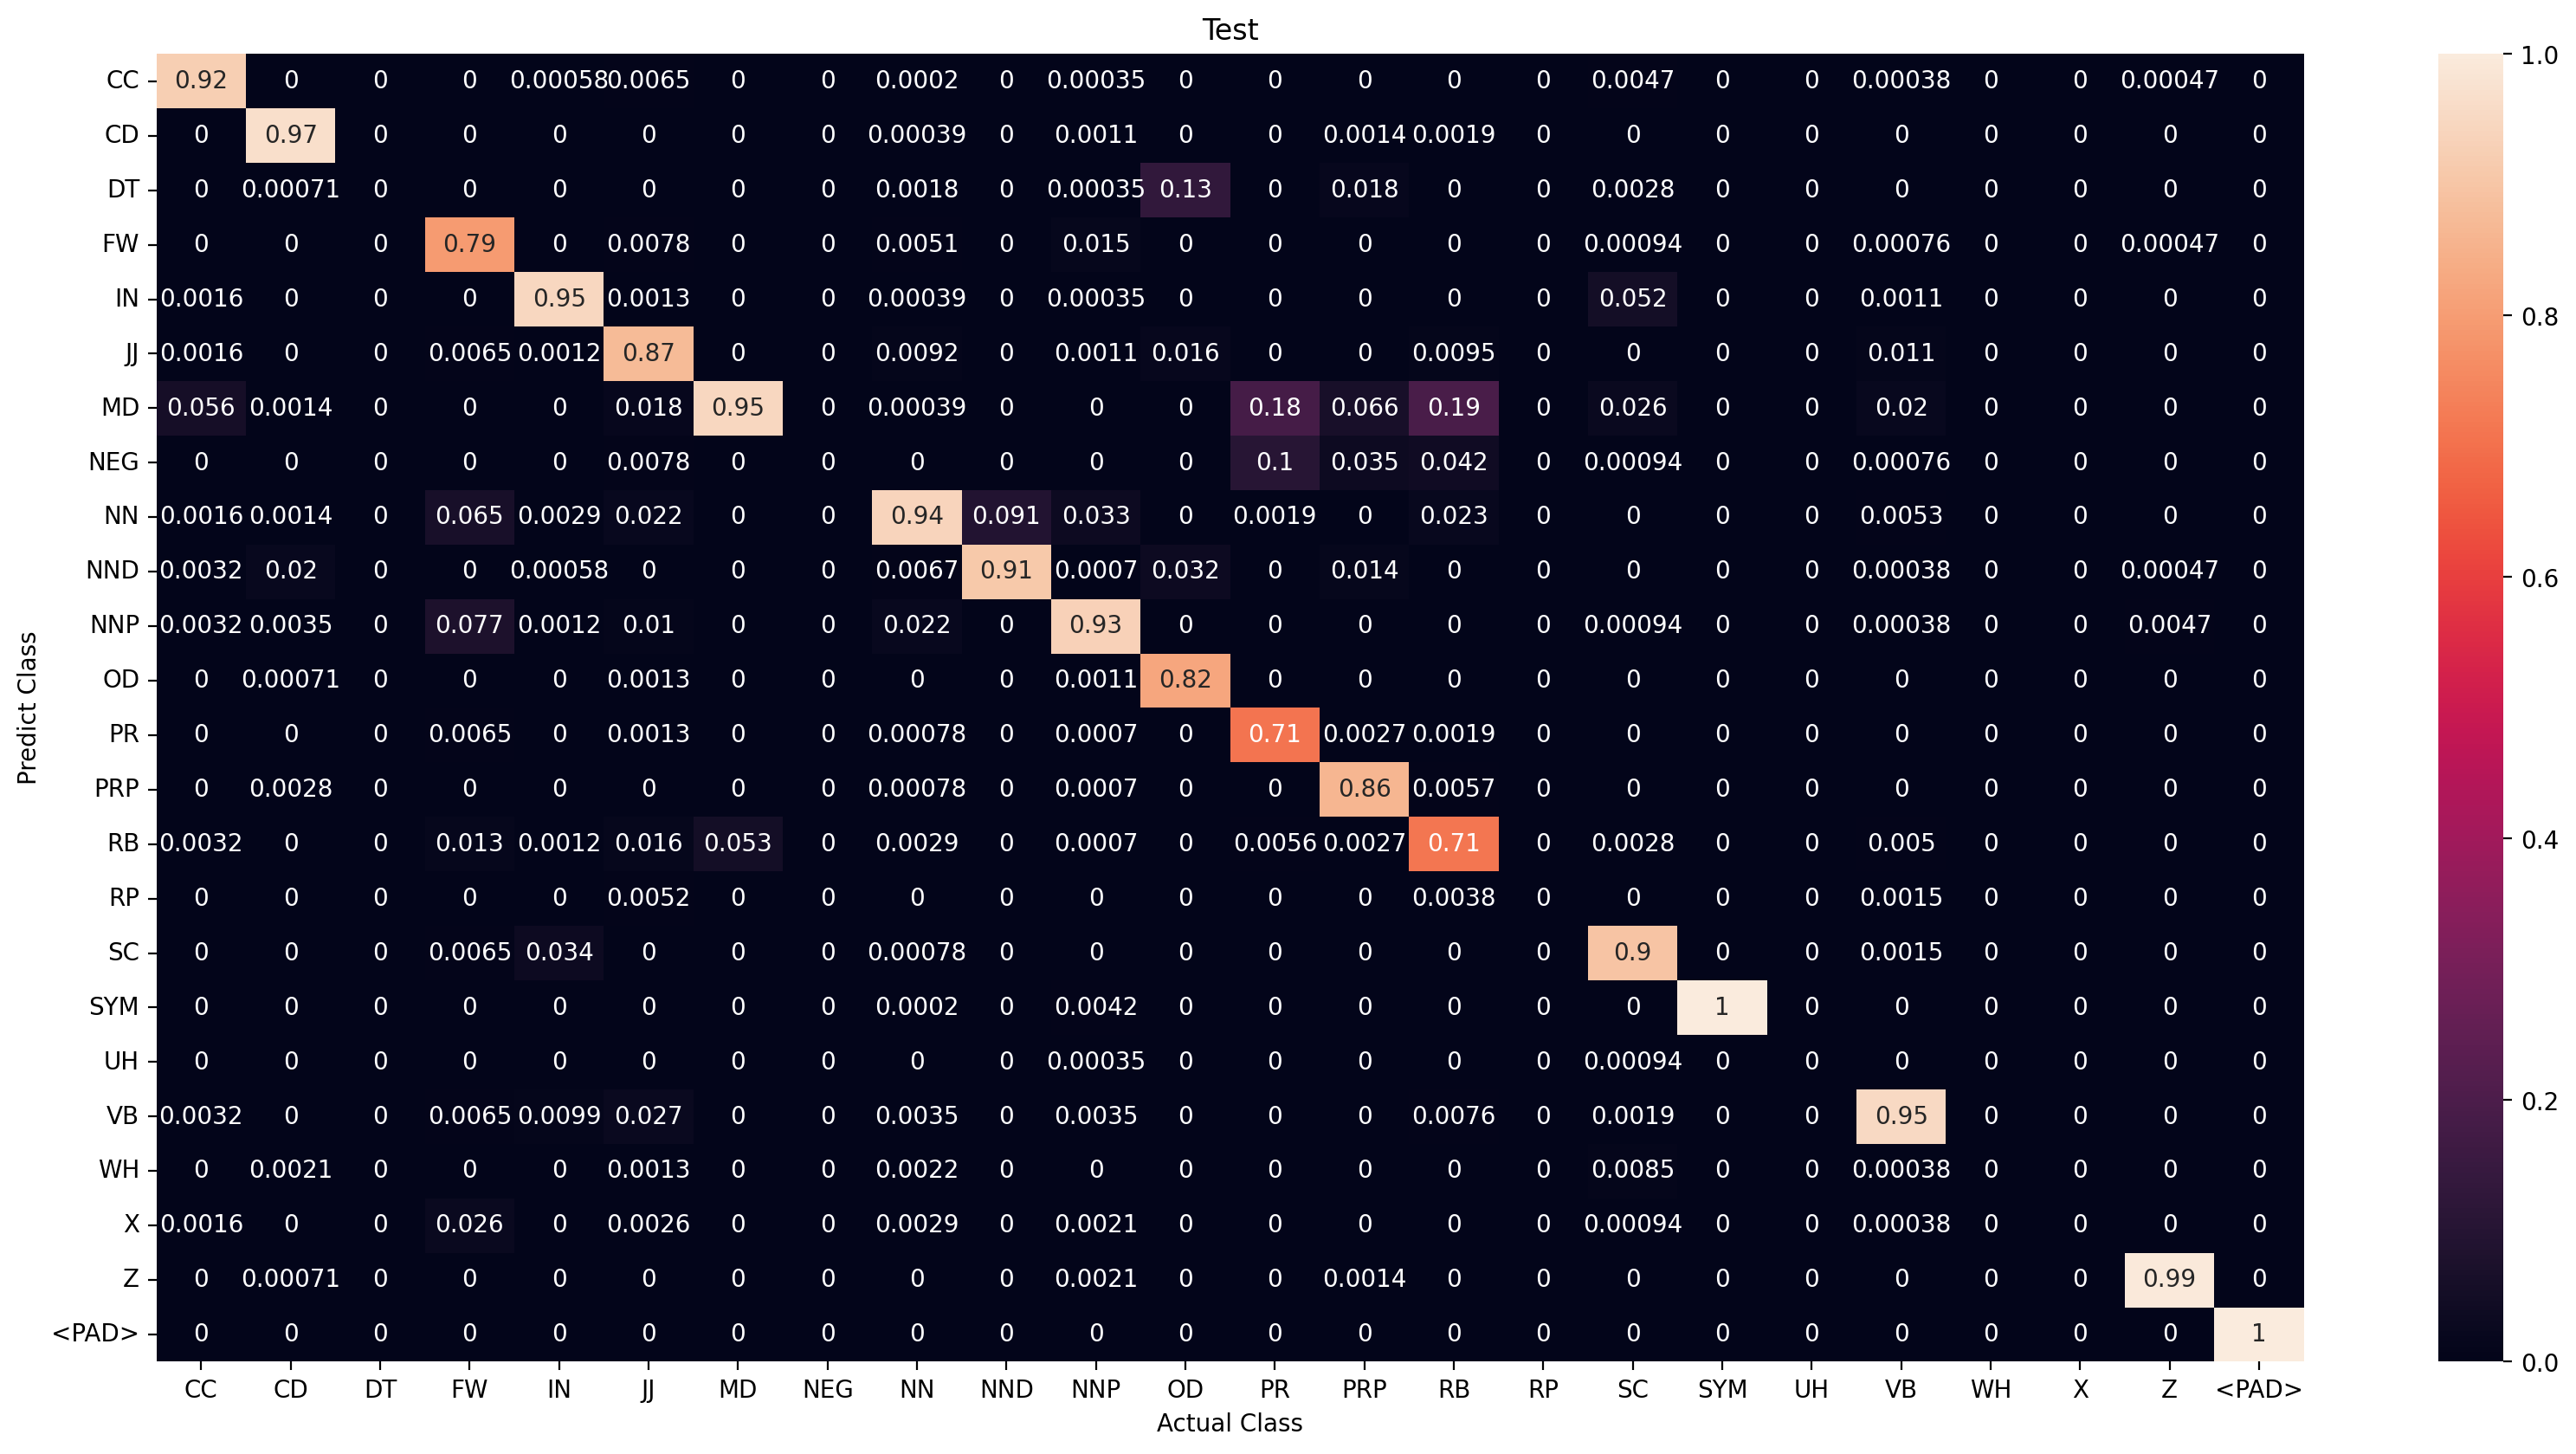

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5280       | CC    : 117      |
| CD    : 12862  | CD    : 12804      | CD    : 58       |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1341       | FW    : 264      |
| IN    : 15290  | IN    : 15149      | IN    : 141      |
| JJ    : 7025   | JJ    : 6703       | JJ    : 322      |
| MD    : 3798   | MD    : 178        | MD    : 3620     |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43936      | NN    : 536      |
| NND   : 1033   | NND   : 363        | NND   : 670      |
| NNP   : 25007  | NNP   : 24566      | NNP   : 441      |
| OD    : 519    | OD    : 500        | OD    : 19       |
| PR    : 3880   | PR    : 3812       | PR    : 68       |
| PRP   : 5449   | PRP   : 5369       | PRP   : 80       |
| RB    : 3502   | RB    : 3295       | RB    : 207      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8, 19, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11316
Wrong prediction            : 655
Percentage correct oov pred : 94.528443739036

Validation
Number OOV token            : 3190
Correct prediction          : 2840
Wrong prediction            : 350
Percentage correct oov pred : 89.0282131661442

Test
Number OOV token            : 1401
Correct prediction          : 1260
Wrong prediction            : 141
Percentage correct oov pred : 89.93576017130621



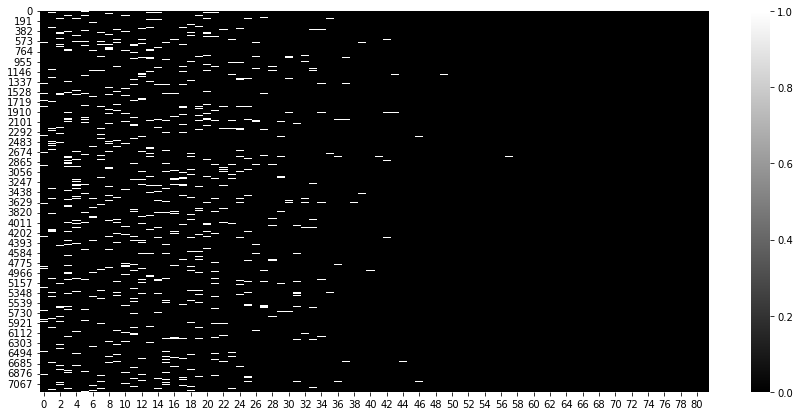

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

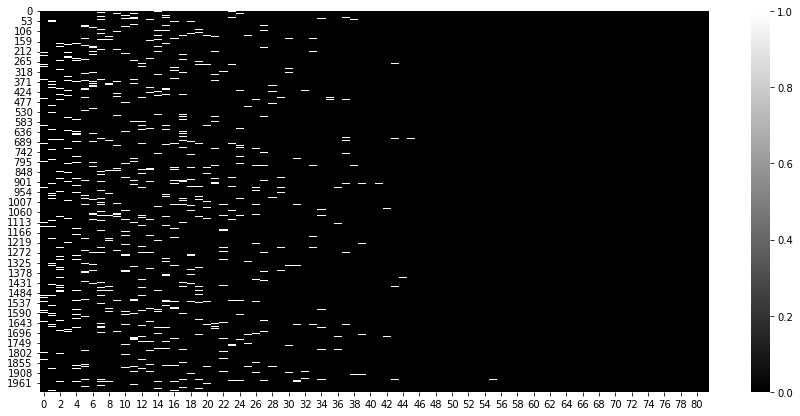

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

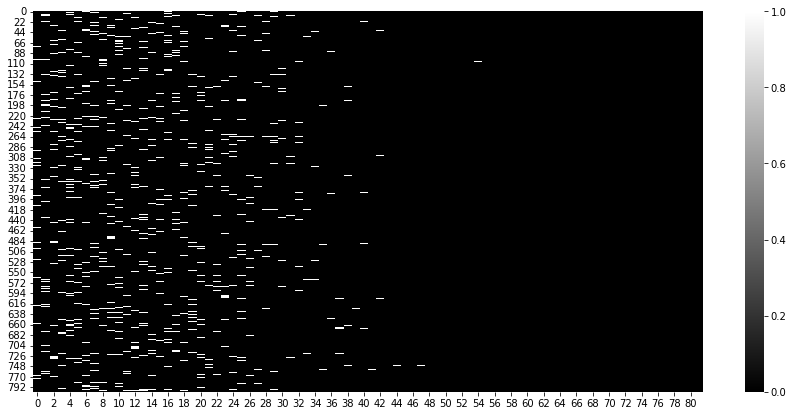

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);